In [1]:
# import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Select Yahoo Finance ticker symbol
ticker= "^SPX"

#ticker = "FTSEMIB.MI"
#ticker = "DAX"
#ticker = "^FCHI"
#ticker ="^IBEX"
#ticker = "^RUT"
#ticker = "^DJI"
#ticker = "^NDX"

#ticker = "BTC-USD"
#ticker = "IWDA.AS"
#ticker = "CSSPX.MI"
#ticker = "XLV"

In [3]:
# download historical data from Yahoo Finance
df = yf.download(ticker, start='1950-01-01', end=None)

C:\Users\calli\AppData\Local\Temp\ipykernel_30560\4060644827.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='1950-01-01', end=None)
[*********************100%***********************]  1 of 1 completed


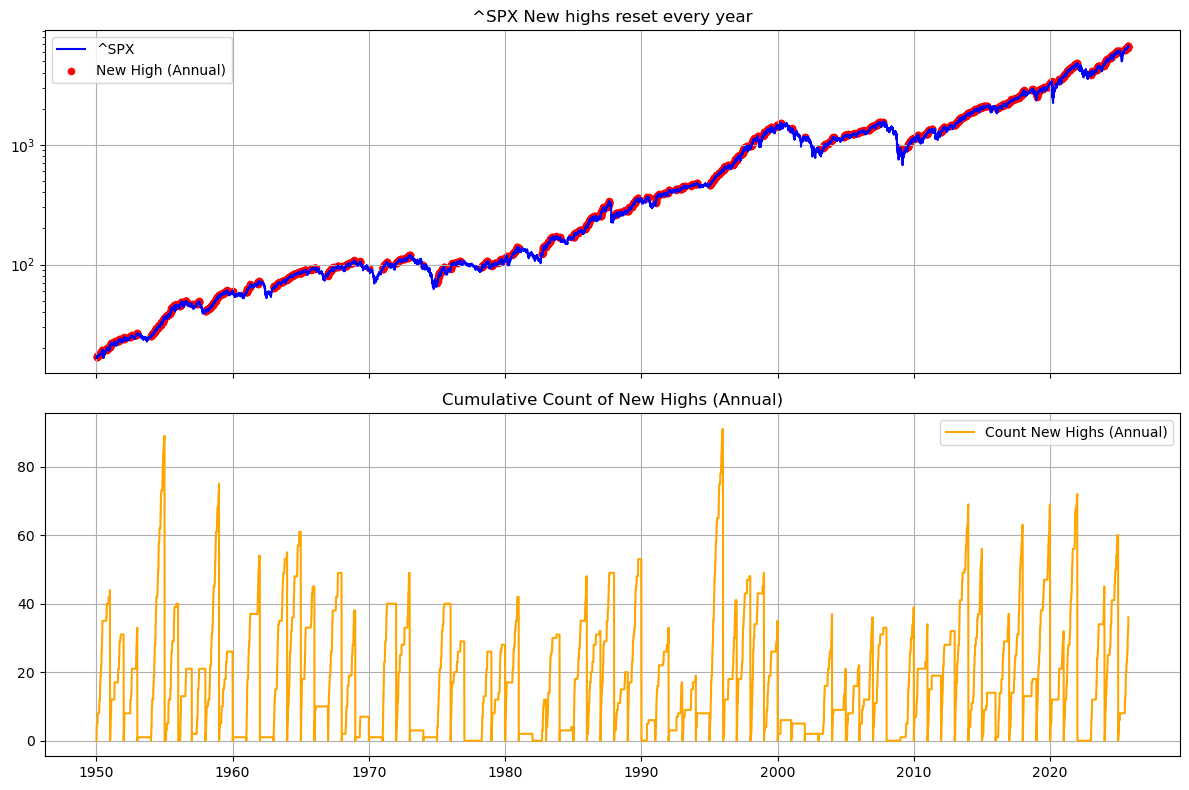

In [4]:
# Flatten the columns if they are a MultiIndex
df.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in df.columns
]
# ('Close', '^GSPC') will become 'Close_^GSPC'.
# If the second level of the MultiIndex is empty, it will return only col[0].

# Systematic Data Cleaning
df.sort_index(inplace=True)
df.dropna(inplace=True)

# Select the correct 'Close' column
close_col = [col for col in df.columns if col.startswith("Close")][0]

# Add a 'year' column for grouping
df['year'] = df.index.year

# Calculate the rolling maximum of the 'Close' price within each year
df['rolling_max_year'] = df.groupby('year')[close_col].cummax()

# Shift the rolling maximum by one day to compare today's close with yesterday's rolling max
df['rolling_max_shifted_year'] = df.groupby('year')['rolling_max_year'].shift(1)

# 8. If today's close > yesterday's rolling max (within the same year) => new high
df['is_new_high_year'] = df[close_col] > df['rolling_max_shifted_year']

# 9. Count cumulatively the new highs, *resetting* at the beginning of each year
df['new_high_count_year'] = df.groupby('year')['is_new_high_year'].cumsum()

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First Chart S&P 500, log scale with red dots for new annual highs
axs[0].set_title(f"{ticker} New highs reset every year")
axs[0].semilogy(df[close_col], label=ticker, color='blue')
axs[0].scatter(
    df.index[df['is_new_high_year']],
    df.loc[df['is_new_high_year'], close_col],
    color='red',
    marker='o',
    s=20,
    label='New High (Annual)'
)
axs[0].legend(loc='best')
axs[0].grid(True)

# Second Chart: Cumulative count of new highs, reset every January 1st
axs[1].set_title("Cumulative Count of New Highs (Annual)")
axs[1].plot(
    df['new_high_count_year'],
    color='orange',
    label='Count New Highs (Annual)'
)
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Supponiamo che la colonna di chiusura si chiami 'Close_^GSPC' (oppure simile, già individuata come close_col)
close_col = [col for col in df.columns if col.startswith("Close")][0]

# 1. Raggruppa per 'year' e aggrega alcune informazioni
yearly_data = (
    df
    .groupby('year')
    .agg(
        number_of_new_highs=('is_new_high_year', 'sum'),  # somma dei True su is_new_high_year
        first_close=(close_col, 'first'),                # primo prezzo di chiusura dell'anno
        last_close=(close_col, 'last')                   # ultimo prezzo di chiusura dell'anno
    )
)

# 2. Calcoliamo il rendimento annuo in percentuale
yearly_data['yearly_return_pct'] = 100.0 * (yearly_data['last_close'] / yearly_data['first_close'] - 1)

# 3. Reset index per mostrare 'year' come colonna, se vogliamo stamparla più comodamente
yearly_data.reset_index(inplace=True)

# 4. Mostriamo il risultato in formato tabellare
print(yearly_data)

# 5. Possiamo fare qualche statistica descrittiva
print("\nStatistiche descrittive:")
print(yearly_data.describe())

# 6. Plottiamo i risultati (numero di nuovi massimi e rendimento annuo) in due grafici a barre
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Numero di nuovi massimi
axes[0].bar(yearly_data['year'], yearly_data['number_of_new_highs'], color='skyblue')
axes[0].set_title(f"{ticker} Numero di Nuovi Massimi per Anno")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y')

# Rendimento annuo in %
axes[1].bar(yearly_data['year'], yearly_data['yearly_return_pct'], color='orange')
axes[1].set_title(f"{ticker} Rendimento Annuo (%)")
axes[1].set_ylabel("%")
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

     
    year  number_of_new_highs  first_close  last_close  yearly_return_pct
0   1998                    4    25.031250   26.000000           3.870162
1   1999                   23    25.937500   30.890625          19.096386
2   2000                    1    30.296875   27.250000         -10.056730
3   2001                   10    26.140625   26.950001           3.096237
4   2002                   14    27.180000   26.549999          -2.317885
5   2003                   14    27.270000   30.150000          10.561053
6   2004                   11    30.219999   30.190001          -0.099268
7   2005                   25    29.840000   31.719999           6.300265
8   2006                   11    32.110001   33.490002           4.297730
9   2007                   23    33.500000   35.310001           5.402989
10  2008                    5    34.939999   26.549999         -24.012592
11  2009                   34    27.090000   31.070000          14.691766
12  2010                    7    31.610001   31.500000          -0.347993
13  2011                   29    31.790001   34.689999           9.122358
14  2012                   42    35.139999   39.880001          13.488907
15  2013                   61    40.669998   55.439999          36.316698
16  2014                   59    55.130001   68.379997          24.034094
17  2015                   24    68.629997   72.029999           4.954104
18  2016                   16    70.730003   68.940002          -2.530752
19  2017                   37    69.839996   82.680000          18.384886
20  2018                   23    83.610001   86.510002           3.468486
21  2019                   40    85.199997  101.860001          19.553996
22  2020                   28   102.129997  113.440002          11.074127
23  2021                   42   112.949997  140.889999          24.736612
24  2022                    2   139.440002  135.850006          -2.574581
25  2023                    3   135.460007  136.380005           0.679166
26  2024                   29   138.779999  137.570007          -0.871877
27  2025                    3   137.610001  139.710007           1.526056

Statistiche descrittive:
              year  number_of_new_highs  first_close  last_close  \
count    28.000000            28.000000    28.000000   28.000000   
mean   2011.500000            22.142857    60.295580   64.352523   
std       8.225975            16.648244    40.576705   42.645833   
min    1998.000000             1.000000    25.031250   26.000000   
25%    2004.750000             9.250000    30.125000   30.715469   
50%    2011.500000            23.000000    35.039999   37.595001   
75%    2018.250000            30.250000    84.007500   90.347502   
max    2025.000000            61.000000   139.440002  140.889999   

       yearly_return_pct  
count          28.000000  
mean            6.851586  
std            11.929653  
min           -24.012592  
25%            -0.161449  
50%             4.625917  
75%            13.789622  
max            36.316698  


import matplotlib.pyplot as plt
import numpy as np

# Assumiamo che 'yearly_data' esista già e abbia almeno queste colonne:
#   - 'year'
#   - 'number_of_new_highs'
#   - 'yearly_return_pct'

# 1) Creiamo una colonna booleana: True se l'anno è stato positivo
yearly_data['is_positive_year'] = yearly_data['yearly_return_pct'] > 0

# 2) Dividiamo in anni positivi e negativi per statistiche descrittive
pos_years = yearly_data[yearly_data['is_positive_year']]
neg_years = yearly_data[~yearly_data['is_positive_year']]

# 3) Stampiamo alcune info basilari
print("===== ANALISI NUOVI MASSIMI vs ANNI POSITIVI =====")
print(f"Anni totali analizzati: {len(yearly_data)}")

print("\n-- Anni Positivi --")
print(f"   Min nuovi massimi: {pos_years['number_of_new_highs'].min()}")
print(f"   Max nuovi massimi: {pos_years['number_of_new_highs'].max()}")
print(f"   Media nuovi massimi: {pos_years['number_of_new_highs'].mean():.1f}")

print("\n-- Anni Negativi --")
print(f"   Min nuovi massimi: {neg_years['number_of_new_highs'].min()}")
print(f"   Max nuovi massimi: {neg_years['number_of_new_highs'].max()}")
print(f"   Media nuovi massimi: {neg_years['number_of_new_highs'].mean():.1f}")

# 4) Mostriamo una tabella di “soglie” di nuovi massimi
#    e probabilità che l'anno sia positivo se la soglia è superata.
print("\n-- Probabilità di Anno Positivo superata una certa soglia di nuovi massimi --")
thresholds = [0, 5, 10, 20, 30, 40, 50, 60, 70]  # soglie di esempio

for t in thresholds:
    subset = yearly_data[yearly_data['number_of_new_highs'] >= t]
    if len(subset) > 0:
        prob_pos = 100.0 * subset['is_positive_year'].mean()
        print(f"   #NuoviMassimi >= {t:2d}:  n={len(subset)} anni,  {prob_pos:.1f}% positivi")
    else:
        print(f"   #NuoviMassimi >= {t:2d}:  nessun anno storico con >= {t} nuovi massimi")

# 5) Scatter Plot: # nuovi massimi (X) vs. rendimento annuo (Y)
plt.figure(figsize=(8, 5))
plt.title(f"{ticker}: Nuovi Massimi vs Rendimento Annuo")
plt.xlabel("Numero di Nuovi Massimi (annuo)")
plt.ylabel("Rendimento Annuo (%)")

# - Anni positivi in verde, anni negativi in rosso
plt.scatter(
    pos_years['number_of_new_highs'],
    pos_years['yearly_return_pct'],
    color='green', label='Anno Positivo'
)
plt.scatter(
    neg_years['number_of_new_highs'],
    neg_years['yearly_return_pct'],
    color='red', label='Anno Negativo'
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     
===== ANALISI NUOVI MASSIMI vs ANNI POSITIVI =====
Anni totali analizzati: 28

-- Anni Positivi --
   Min nuovi massimi: 3
   Max nuovi massimi: 61
   Media nuovi massimi: 26.8

-- Anni Negativi --
   Min nuovi massimi: 1
   Max nuovi massimi: 29
   Media nuovi massimi: 10.6

-- Probabilità di Anno Positivo superata una certa soglia di nuovi massimi --
   #NuoviMassimi >=  0:  n=28 anni,  71.4% positivi
   #NuoviMassimi >=  5:  n=23 anni,  73.9% positivi
   #NuoviMassimi >= 10:  n=21 anni,  81.0% positivi
   #NuoviMassimi >= 20:  n=15 anni,  93.3% positivi
   #NuoviMassimi >= 30:  n=7 anni,  100.0% positivi
   #NuoviMassimi >= 40:  n=5 anni,  100.0% positivi
   #NuoviMassimi >= 50:  n=2 anni,  100.0% positivi
   #NuoviMassimi >= 60:  n=1 anni,  100.0% positivi
   #NuoviMassimi >= 70:  nessun anno storico con >= 70 nuovi massimi


import matplotlib.pyplot as plt
import numpy as np

# Esempio: supponendo di avere already un DataFrame yearly_data con
#  - 'year'
#  - 'number_of_new_highs'
#  - 'yearly_return_pct'
# e magari una variabile 'ticker' con il nome del ticker (es. '^GSPC').

# 1) Ordina i dati per 'year'
yearly_data = yearly_data.sort_values('year')

# 2) Creiamo la colonna con il RENDIMENTO DELL'ANNO SUCCESSIVO
yearly_data['next_year_return_pct'] = yearly_data['yearly_return_pct'].shift(-1)

# 3) Colonna booleana: Anno Successivo Positivo
yearly_data['is_positive_next_year'] = yearly_data['next_year_return_pct'] > 0

# 4) Dividiamo in "anni con successivo positivo" e "anni con successivo negativo"
pos_next = yearly_data[yearly_data['is_positive_next_year']]
neg_next = yearly_data[~yearly_data['is_positive_next_year']]

# 5) Stampiamo alcune info basilari
print("===== ANALISI NUOVI MASSIMI vs RENDIMENTO ANNO SUCCESSIVO =====")
print(f"Anni totali analizzati (con anno successivo presente): {len(yearly_data) - 1}")
# (l'ultimo anno non ha un "anno successivo" nei dati, quindi una riga va persa in shift)

print("\n-- Anno con Next Year Positivo --")
if len(pos_next) > 0:
    print(f"   Min nuovi massimi (anno corrente): {pos_next['number_of_new_highs'].min()}")
    print(f"   Max nuovi massimi (anno corrente): {pos_next['number_of_new_highs'].max()}")
    print(f"   Media nuovi massimi: {pos_next['number_of_new_highs'].mean():.1f}")
else:
    print("   Nessun anno con successivo positivo (strano!)")

print("\n-- Anno con Next Year Negativo --")
if len(neg_next) > 0:
    print(f"   Min nuovi massimi (anno corrente): {neg_next['number_of_new_highs'].min()}")
    print(f"   Max nuovi massimi (anno corrente): {neg_next['number_of_new_highs'].max()}")
    print(f"   Media nuovi massimi: {neg_next['number_of_new_highs'].mean():.1f}")
else:
    print("   Nessun anno con successivo negativo (fortuna!)")

# 6) Tabella di soglie di nuovi massimi vs prob. di avere anno SUCCESSIVO positivo
print("\n-- Probabilità di Anno Successivo Positivo superata una certa soglia di nuovi massimi --")
thresholds = [0, 5, 10, 20, 30, 40, 50, 60, 70]

for t in thresholds:
    subset = yearly_data[yearly_data['number_of_new_highs'] >= t]
    # Solo anni che superano la soglia 't' di nuovi massimi
    # (Attenzione: l'ultimo anno in dataset non ha "next_year_return_pct", quindi subset potrà escluderlo)
    if len(subset) > 0:
        prob_pos = 100.0 * subset['is_positive_next_year'].mean()
        print(f"   #NuoviMassimi >= {t:2d}:  n={len(subset)} anni,  {prob_pos:.1f}% successivi positivi")
    else:
        print(f"   #NuoviMassimi >= {t:2d}:  nessun anno storico con >= {t} nuovi massimi")

# 7) Scatter Plot:
#    Asse X = # nuovi massimi nell'anno corrente
#    Asse Y = Rendimento dell'anno successivo
plt.figure(figsize=(8, 5))
plt.title(f"{ticker}: # Nuovi Massimi (Anno Corrente) vs Rendimento Anno Successivo")
plt.xlabel("Numero di Nuovi Massimi (anno corrente)")
plt.ylabel("Rendimento Anno Successivo (%)")

# - Anni con successivo positivo in verde, successivo negativo in rosso
plt.scatter(
    pos_next['number_of_new_highs'],
    pos_next['next_year_return_pct'],
    color='green', label='Anno Successivo Positivo'
)
plt.scatter(
    neg_next['number_of_new_highs'],
    neg_next['next_year_return_pct'],
    color='red', label='Anno Successivo Negativo'
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     
===== ANALISI NUOVI MASSIMI vs RENDIMENTO ANNO SUCCESSIVO =====
Anni totali analizzati (con anno successivo presente): 27

-- Anno con Next Year Positivo --
   Min nuovi massimi (anno corrente): 1
   Max nuovi massimi (anno corrente): 61
   Media nuovi massimi: 23.4

-- Anno con Next Year Negativo --
   Min nuovi massimi (anno corrente): 3
   Max nuovi massimi (anno corrente): 42
   Media nuovi massimi: 19.6

-- Probabilità di Anno Successivo Positivo superata una certa soglia di nuovi massimi --
   #NuoviMassimi >=  0:  n=28 anni,  67.9% successivi positivi
   #NuoviMassimi >=  5:  n=23 anni,  69.6% successivi positivi
   #NuoviMassimi >= 10:  n=21 anni,  66.7% successivi positivi
   #NuoviMassimi >= 20:  n=15 anni,  66.7% successivi positivi
   #NuoviMassimi >= 30:  n=7 anni,  71.4% successivi positivi
   #NuoviMassimi >= 40:  n=5 anni,  80.0% successivi positivi
   #NuoviMassimi >= 50:  n=2 anni,  100.0% successivi positivi
   #NuoviMassimi >= 60:  n=1 anni,  100.0% successivi positivi
   #NuoviMassimi >= 70:  nessun anno storico con >= 70 nuovi massimi


SyntaxError: invalid syntax (172240323.py, line 1)